In [1]:
import pandas as pd
import cv2
import numpy as np
import json
import heapq
import os
import matplotlib.pyplot as plt
from localize import CombineCam

In [3]:
def top_k_results(ious_dict, k=10, reverse=False):
    """Get the top k images with maximum IoU scores.

    Args:
        ious_dict (dict): A dictionary containing the IoU scores of all images.
        reverse (bool, optional): If True, return the top k images with minimum IoU scores. Defaults to False.

    Returns:
        list: A list containing the top k images with maximum IoU scores.
    """
    
    # Get the top k images with maximum IoU scores
    if reverse == True:
        top_ious = heapq.nsmallest(k, ious_dict.items(), key=lambda x: x[1]['IoU'])
    else:
        top_ious = heapq.nlargest(k, ious_dict.items(), key=lambda x: x[1]['IoU'])
    
    # Retrieve image names, proposed boxes, and ground truth boxes from the top k maximun IoU scores
    image_names = [name for name, _ in top_ious]
    iou_score = [box['IoU'] for _, box in top_ious]
    proposed_boxes = [box['proposed_boxes'] for _, box in top_ious]
    gt_boxes = [box['ground_truth'] for _, box in top_ious]
    
    return image_names, iou_score, proposed_boxes, gt_boxes

In [ ]:
def show_results_by_image(ious_dict, src_dir, image_name):
    """
    Show the results of a single image.
    """
    image_path = os.path.join(src_dir, f'{image_name}.jpg')
    image_info = ious_dict[image_name]
    iou_score = image_info['IoU']
    pred_boxes = image_info['proposed_boxes']
    gt_boxes = image_info['ground_truth']

    image = cv2.imread(image_path)[:,:,::-1]
    img = image.copy()
    draw_boxes(img, pred_boxes, (255, 0, 0))
    show_normalized_image(img)

In [4]:
def draw_boxes(image, boxes, color):
    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    
def put_text(image, text, pos=(20, 40)):
    cv2.putText(image, text, pos, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
def show_normalized_image(img):
    plt.imshow(img.astype("uint8"))
    plt.axis("off")
    plt.show()
    
def show_topk_image(ious_dict, k, image_dir, reverse=False):
    han = top_k_results(ious_dict, k, reverse)
    img, iou, pred_boxes, gt_boxes = han
    zipped_list = zip(img, iou, pred_boxes, gt_boxes)
    for img_name, iou, pred_boxes, gt_boxes in zipped_list:
        image_path = os.path.join(image_dir, f'{img_name}.jpg')
        print(f'Image: {image_path}')
        print(f'Predicted: {pred_boxes}')
        print(f'Ground truth: {gt_boxes}')
        image = cv2.imread(image_path)[:, :, ::-1]
        
        img = image.copy()
        draw_boxes(img, pred_boxes, (255, 255, 255))
        draw_boxes(img, gt_boxes, (255, 0, 0))
        put_text(img, text=img_name)
        put_text(img, text=f'IoU: {iou:.2f}', pos=(20, 80))
        show_normalized_image(img)

In [5]:
options = {1: None,  # scale at the MR image size (512)
            2: 'scale0.25',
            3: 'scale1',
            4: 'scale0.25_0.5',
            5: 'attention',
            6: 'multiscale',
            7: 'multi_attention',
            8: 'multi_slic',
            9: 'multi_watershed',
            10: 'multi_selectivesearch'}

def get_ious_dict(threshold, image_dir, result_dict, option):
    localizer = CombineCam(threshold=threshold, 
                       checkpoint_path='./results/tb_logs/lightning_logs/version_45/checkpoints/best_model_012-0.1648-0.94.ckpt',
                       json_file='./ground-truth-bbox/inference_modified_original.json')
    avg_iou, ious_dict = localizer.evaluate_all(image_dir, 
                                            result_dict,
                                            file_path='cropped_image_path',
                                            coord='crop_coordinates_ratio',
                                            option=option)
    
    return avg_iou, ious_dict

In [206]:
image_name = '23945062_20211104_125438_739'

In [ ]:
# Multi-scale
avg_iou, ious_dict = get_ious_dict(threshold=0.8,
                                   image_dir = '/root/data/apple/cropped-apple-bb/images/',
                                   result_dict = './multiscale-dict/with-vit/multiscale_vit.pickle',
                                   option=options[6])

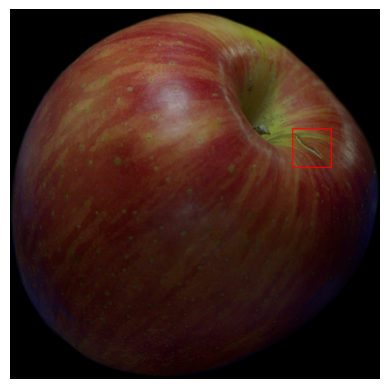

In [207]:
show_results_by_image(ious_dict=ious_dict,
                      src_dir='/root/data/apple/cropped-apple-bb/images/',
                      image_name=image_name)

In [ ]:
# Multi-scale + Attention
avg_iou_att, ious_dict_att = get_ious_dict(threshold=0.45,
                                   image_dir = '/root/data/apple/cropped-apple-bb/images/',
                                   result_dict = './multiscale-dict/with-vit/multiscale_vit.pickle',
                                   option=options[7])

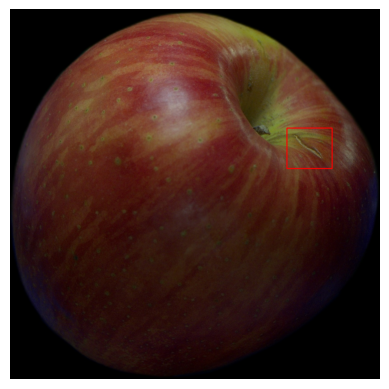

In [208]:
show_results_by_image(ious_dict=ious_dict_att,
                      src_dir='/root/data/apple/cropped-apple-bb/images/',
                      image_name=image_name)

In [ ]:
# Multi-scale + SLIC
avg_iou_slic, ious_dict_slic = get_ious_dict(threshold=0.7,
                                   image_dir = '/root/data/apple/cropped-apple-bb/images/',
                                   result_dict = './multiscale-dict/with-vit/multiscale_vit.pickle',
                                   option=options[7])

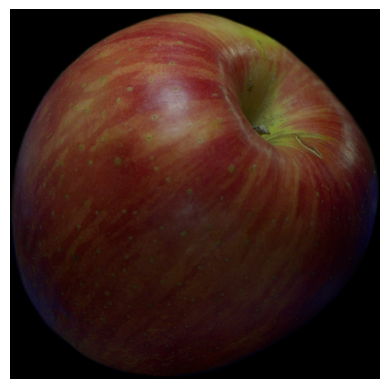

In [209]:
show_results_by_image(ious_dict=ious_dict_slic,
                      src_dir='/root/data/apple/cropped-apple-bb/images/',
                      image_name=image_name)

In [ ]:
# Multi-scale + Watershed
avg_iou_shed, ious_dict_shed = get_ious_dict(threshold=0.8,
                                   image_dir = '/root/data/apple/cropped-apple-bb/images/',
                                   result_dict = './multiscale-dict/with-vit/multiscale_vit.pickle',
                                   option=options[9])

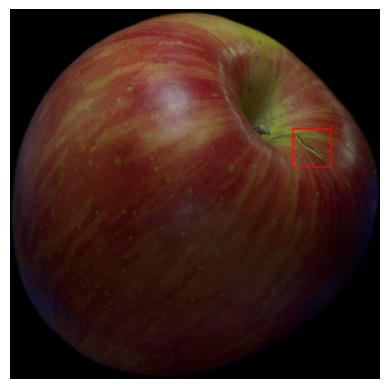

In [211]:
show_results_by_image(ious_dict=ious_dict_shed,
                      src_dir='/root/data/apple/cropped-apple-bb/images/',
                      image_name=image_name)

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211104_163401_748.jpg
Predicted: [(65, 569, 293, 746)]
Ground truth: [(66, 569, 290, 725)]


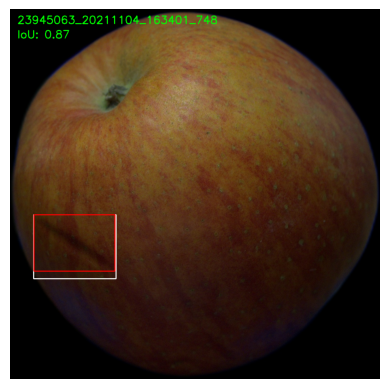

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211025_205158_654.jpg
Predicted: [(704, 586, 772, 681)]
Ground truth: [(707, 584, 775, 665)]


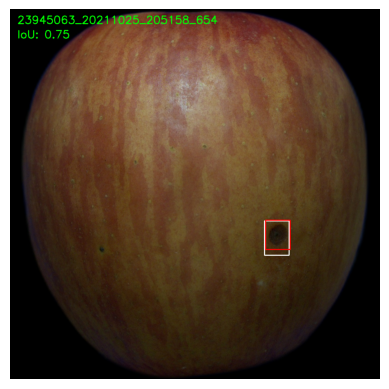

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_151358_336.jpg
Predicted: [(724, 194, 791, 258)]
Ground truth: [(731, 194, 784, 251)]


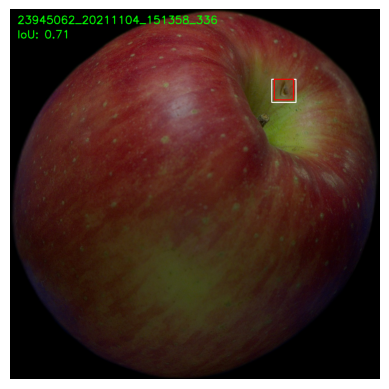

Image: /root/data/apple/cropped-apple-bb/images/23945065_20211104_154503_250.jpg
Predicted: [(735, 394, 831, 474)]
Ground truth: [(734, 398, 815, 485)]


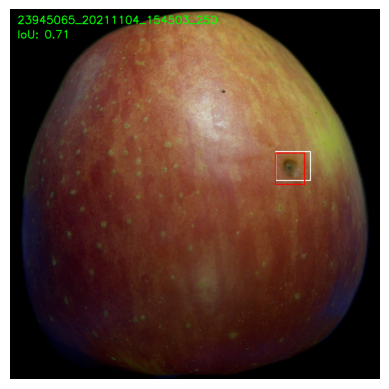

Image: /root/data/apple/cropped-apple-bb/images/23945065_20211104_140453_739.jpg
Predicted: [(575, 644, 649, 719)]
Ground truth: [(148, 691, 198, 745), (569, 630, 647, 712), (675, 770, 726, 823)]


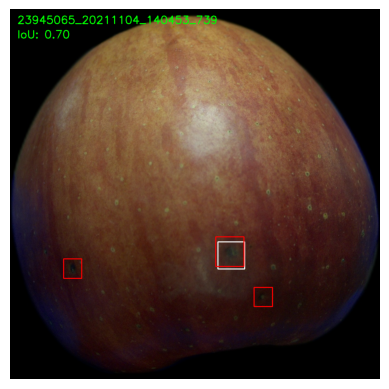

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_155622_744.jpg
Predicted: [(772, 739, 831, 799)]
Ground truth: [(772, 734, 827, 787)]


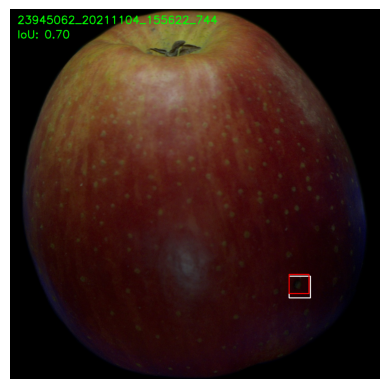

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211025_151148_217.jpg
Predicted: [(745, 279, 833, 350)]
Ground truth: [(740, 280, 813, 354), (145, 360, 194, 412)]


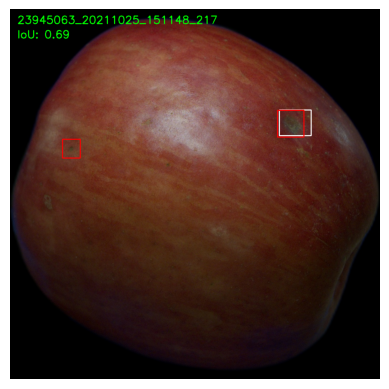

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211104_130548_746.jpg
Predicted: [(607, 612, 751, 806)]
Ground truth: [(601, 627, 721, 801)]


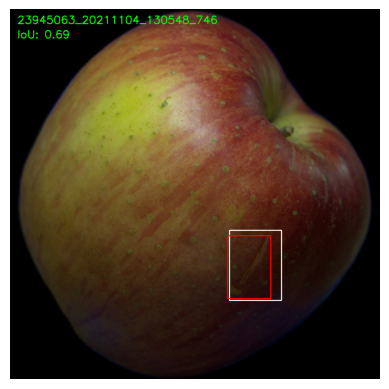

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211104_160840_159.jpg
Predicted: [(573, 227, 648, 305)]
Ground truth: [(569, 227, 639, 289)]


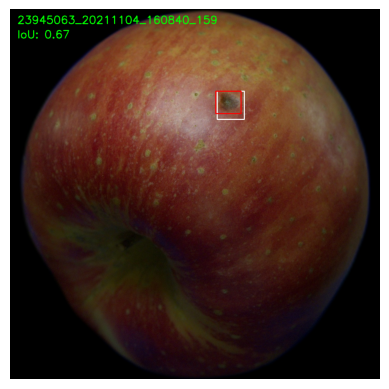

Image: /root/data/apple/cropped-apple-bb/images/23945065_20211104_153342_845.jpg
Predicted: [(806, 299, 890, 388)]
Ground truth: [(809, 290, 874, 381)]


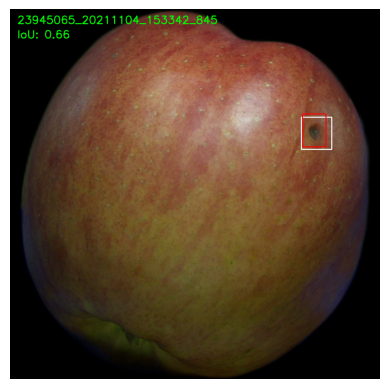

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_125438_739.jpg
Predicted: [(782, 331, 889, 438)]
Ground truth: [(778, 339, 872, 425)]


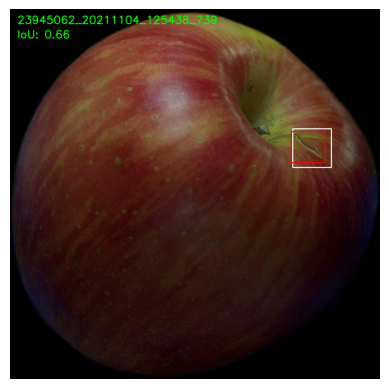

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_144025_745.jpg
Predicted: [(741, 400, 852, 500)]
Ground truth: [(737, 400, 820, 493)]


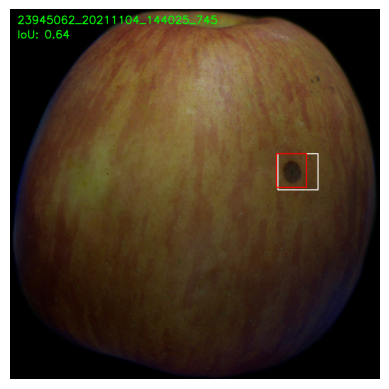

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211104_143639_338.jpg
Predicted: [(48, 412, 125, 483)]
Ground truth: [(46, 414, 101, 486)]


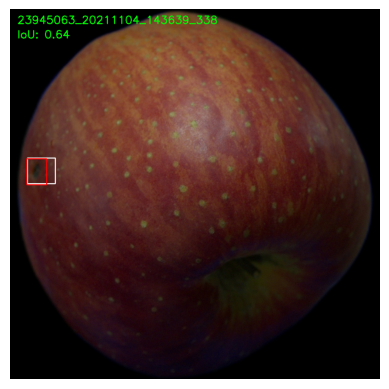

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_151217_837.jpg
Predicted: [(785, 293, 873, 386)]
Ground truth: [(795, 305, 864, 380)]


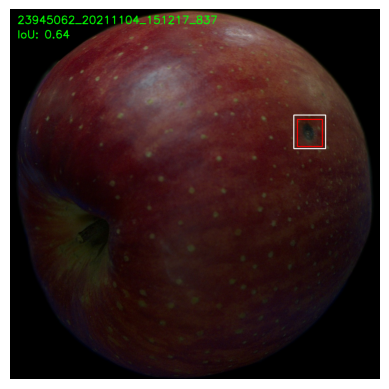

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_135701_621.jpg
Predicted: [(37, 413, 109, 471)]
Ground truth: [(40, 422, 128, 468), (176, 456, 216, 507)]


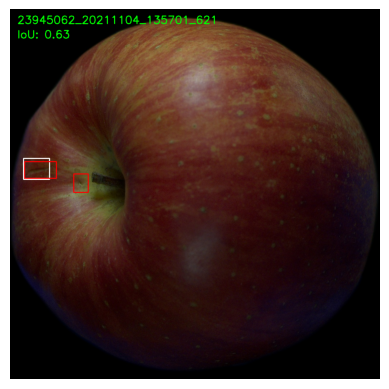

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_150446_338.jpg
Predicted: [(419, 495, 500, 585)]
Ground truth: [(414, 504, 489, 572)]


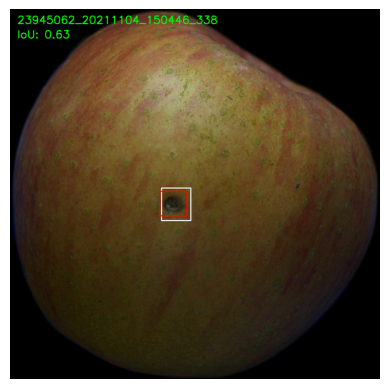

Image: /root/data/apple/cropped-apple-bb/images/23945062_20211104_161740_148.jpg
Predicted: [(493, 189, 598, 311)]
Ground truth: [(363, 177, 635, 239), (484, 181, 609, 345)]


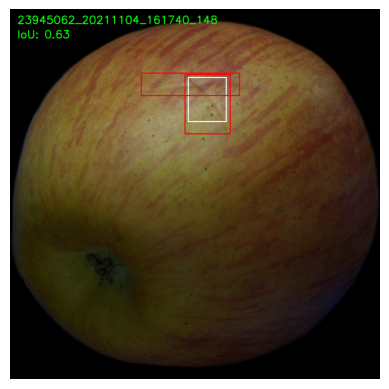

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211025_221720_633.jpg
Predicted: [(550, 66, 638, 152)]
Ground truth: [(543, 69, 633, 128), (108, 476, 154, 515), (72, 489, 115, 537)]


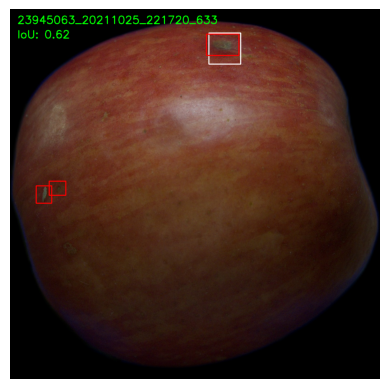

Image: /root/data/apple/cropped-apple-bb/images/23945065_20211104_133158_739.jpg
Predicted: [(532, 474, 604, 546)]
Ground truth: [(522, 473, 583, 545), (587, 494, 649, 559), (622, 562, 679, 612)]


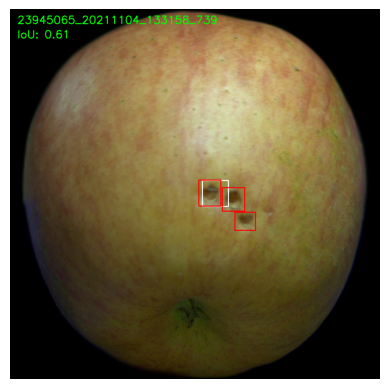

Image: /root/data/apple/cropped-apple-bb/images/23945063_20211025_155727_650.jpg
Predicted: [(133, 448, 232, 555)]
Ground truth: [(107, 445, 211, 554), (752, 320, 809, 379)]


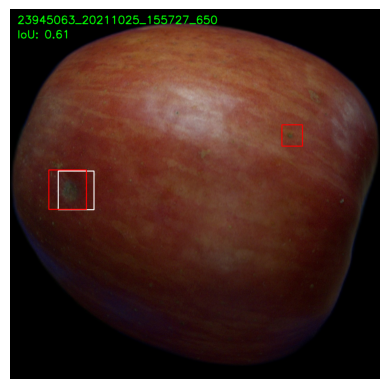

In [205]:
show_topk_image(ious_dict, k=20, image_dir='/root/data/apple/cropped-apple-bb/images/', reverse=False)